# Tokens cleaning and study

In [1]:
import sys
sys.path.append("..")

import json
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

from src.dataset import Dataset

## Tokens analysis and cleaning

We start by loading the tokens and by plotting the document length.

In [2]:
dataset = Dataset()
tokens = dataset.load_dataset(tokens=True)

In [3]:
tokens = [[t for t in doc if len(t) >= 3] for doc in tokens]

In [4]:
x = [len(x) for x in tokens]

fun = [max, min, np.mean, np.std]

print("Length stats:")
pprint([(f.__name__, f(x)) for f in fun])

Length stats:
[('max', 27977),
 ('min', 0),
 ('mean', 916.9110491083617),
 ('std', 990.0464025487191)]


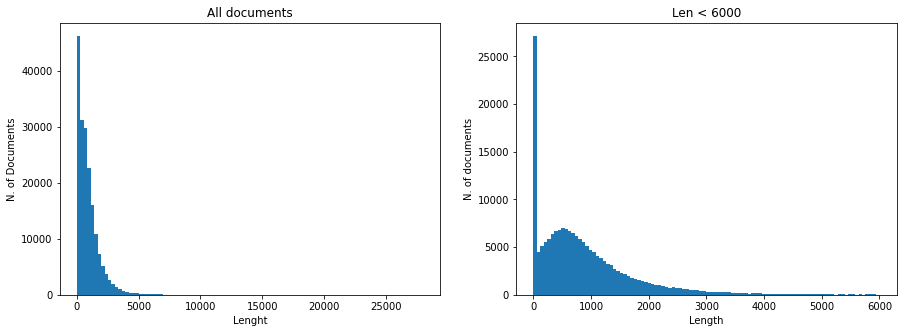

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(x, bins=100)
axs[1].hist(list(filter(lambda x:x<6000, x)), bins=100)
axs[0].set(title= "All documents", 
           xlabel="Lenght", ylabel="N. of Documents")
axs[1].set(title= "Len < 6000", 
           xlabel="Lenght", ylabel="N. of Documents")

plt.xlabel("Length")
plt.ylabel("N. of documents")
plt.show()

### Zipf curve

We start by computing the document frequency for each token, we can clearly see some tokens are heavily used, mean and max are really distant.

In [6]:
freqs = defaultdict(lambda:0)

for doc in tokens:
    for t in set(doc):
        freqs[t] += 1

freq_list = list(freqs.values())

In [7]:
print("Terms frequency stats:")
pprint([(f.__name__, f(freq_list)) for f in fun])
print(f"Vocabulary length: {len(freq_list)}")

Terms frequency stats:
[('max', 171091),
 ('min', 1),
 ('mean', 175.73826989949032),
 ('std', 2538.302272263149)]
Vocabulary length: 335888


We now consider terms that appear at least min_cutoff times. 

In [8]:
max_cutoff = 0.35*len(tokens)
min_cutoff = 10

h = lambda x : min_cutoff <= x <= max_cutoff
nh = lambda x : x < min_cutoff or x > max_cutoff

filtered_freq_list = list(filter(h, freq_list))
print("Filtered terms frequency stats:")
pprint([(f.__name__, f(filtered_freq_list)) for f in fun])
len(filtered_freq_list)

Filtered terms frequency stats:
[('max', 64043),
 ('min', 10),
 ('mean', 756.5996872170549),
 ('std', 3867.5878125991117)]


60745

In [9]:
print(f"The most common term appears in the {round(max(filtered_freq_list)/len(tokens), 2)}% of documents.")
print(f"There are {len(list(filter(nh, freq_list)))} terms that appear more than {int(max_cutoff)} or less than {min_cutoff} times.")

The most common term appears in the 0.35% of documents.
There are 275143 terms that appear more than 64101 or less than 10 times.


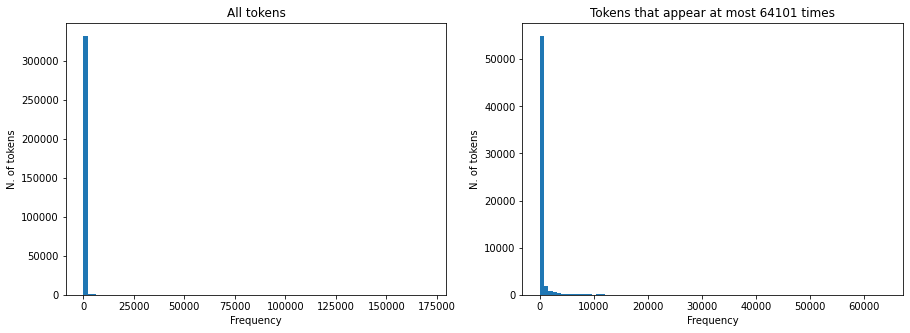

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(freq_list, bins=80)
axs[1].hist(filtered_freq_list, bins=80)
axs[0].set(title= "All tokens", 
           xlabel="Frequency", ylabel="N. of tokens")
axs[1].set(title= f"Tokens that appear at most {int(max_cutoff)} times", 
           xlabel="Frequency", ylabel="N. of tokens")

plt.show()

## Searching terms about three topics

We start by checking for the presence of drugs, weapons and investigation terms.

In [11]:
narcotics = ['cannabis', 'cocaine', 'methamphetamine', 'drugs', 'drug', 'marijuana', 
             'ecstasy', 'lsd', 'ketamine', 'heroin', 'fentanyl', 'overdose']

weapons = ['gun', 'knife', 'weapon', 'firearm', 'rifle', 'carabine', 'shotgun', 'handgun', 
           'revolver', 'musket', 'pistol', 'derringer', 'assault', 'rifle', 'sword', 'blunt']

investigation = ['gang', 'mafia', 'serial',  'killer', 'rape', 'theft', 'recidivism', 
                 'arrest', 'robbery', 'cybercrime', 'cyber', 'crime']

#'caucasian','afro-american','native', 'american','hispanic',
#'male','female','man','woman','girl','boy',

### Collect and remove unused terms

The vocabulary drastically shrinks from 450k to 71k words by filtering out the terms that appears less than 9 times, this can be seen in later vectorization, but also from the stats presented above.

In [12]:
irrelevant_terms = set([ k for k,v in freqs.items() if nh(v)])

for e in weapons + investigation + narcotics:
    if e in irrelevant_terms:
        irrelevant_terms.remove(e)

print(len(irrelevant_terms))
list(irrelevant_terms)[:10]

275138


['otest',
 'brez',
 'imbursements',
 'weiwel',
 'ajproviso',
 'hanberry',
 'ofijryear',
 'purchaseimoney',
 'notieé',
 'greenwoods']

In [13]:
filtered_tokens = [[t for t in doc if t not in irrelevant_terms] for doc in tokens]

In [14]:
with open("../data/processed/filtered_tokens.json", "w") as f: 
    f.write(json.dumps(filtered_tokens))
    
# filtered_tokens = json.load(open("../data/processed/filtered_tokens.json", "r"))

In [15]:
seen = set()
not_found = set(weapons + investigation + narcotics)
freq = defaultdict(lambda:0)
for doc in filtered_tokens:
    # if not not_found:
    #     break
    for w in set(doc): 
        if w in not_found:
            # not_found.remove(w)
            seen.add(w)
            freq[w] += 1

In [16]:
pprint(sorted([(v,k) for k,v in freq.items()]))
print("Not found")
pprint(not_found-seen)

[(3, 'ketamine'),
 (5, 'cyber'),
 (5, 'fentanyl'),
 (6, 'musket'),
 (9, 'ecstasy'),
 (46, 'mafia'),
 (69, 'derringer'),
 (132, 'methamphetamine'),
 (137, 'drugs'),
 (199, 'recidivism'),
 (219, 'overdose'),
 (221, 'lsd'),
 (357, 'sword'),
 (536, 'killer'),
 (667, 'serial'),
 (772, 'blunt'),
 (937, 'rifle'),
 (1461, 'heroin'),
 (1523, 'cannabis'),
 (1549, 'handgun'),
 (1572, 'shotgun'),
 (2014, 'marijuana'),
 (2054, 'gang'),
 (2445, 'firearm'),
 (2683, 'cocaine'),
 (2709, 'pistol'),
 (2784, 'revolver'),
 (3635, 'knife'),
 (3810, 'rape'),
 (5984, 'theft'),
 (7646, 'assault'),
 (7757, 'weapon'),
 (8884, 'drug'),
 (8982, 'robbery'),
 (9337, 'gun'),
 (23202, 'arrest'),
 (23793, 'crime')]
Not found
{'cybercrime', 'carabine'}
